In [1]:
import xupy as xp
import matplotlib.pyplot as plt
from numpy.ma import masked_array

from ekarus.e2e.utils.image_utils import reshape_on_mask, image_grid, get_circular_mask

from ekarus.e2e.single_stage_ao_class import SingleStageAO


[XuPy] Device 0 available - GPU : `NVIDIA GeForce RTX 4060 Laptop GPU`
       Memory = 7805.56 MB | Compute Capability = 8.9
       Using CuPy 13.5.1 for acceleration.


In [2]:
def define_target_roi(pupil, iwa, owa, oversampling:int, symmetric:bool=False, heightInLambdaOverD=None):
    mask_shape = max(pupil.shape)
    padded_pupil = xp.pad(1-pupil.copy(), pad_width=int((mask_shape*(oversampling-1)//2)), mode='constant', constant_values=0.0)
    X,Y = image_grid(padded_pupil.shape,recenter=True)
    rho = xp.sqrt(X**2+Y**2)
    if symmetric is True:
        where = (rho <= owa*oversampling) * (rho >= iwa*oversampling)
    else:
        where = (rho <= owa*oversampling) * (X >= iwa*oversampling) 
    if heightInLambdaOverD is not None:
        where *= (abs(Y) < heightInLambdaOverD/2*oversampling)
    return where

def calc_psf(ef, oversampling:int=8, fp_mask=None, lyot_stop=None):
    pad_width = int((max(ef.shape)*(oversampling-1)//2))
    pad_ef = xp.pad(ef, pad_width=pad_width, mode='constant', constant_values=0.0)
    ff = xp.fft.fftshift(xp.fft.fft2(pad_ef))
    if fp_mask is not None:
        ff *= fp_mask
    if lyot_stop is not None:
        pad_lyot = xp.pad(lyot_stop, pad_width=pad_width, mode='constant', constant_values=0.0)
        pf = xp.fft.ifft2(xp.fft.ifftshift(ff))
        ff = xp.fft.fftshift(xp.fft.fft2(pf * pad_lyot))
    return xp.real(ff * xp.conj(ff))

def show_psf(psf, norm=None, oversampling:int=8, title:str='', ext=0.3, vmin=-10):
    pixelSize = 1/oversampling
    imageHalfSizeInPoints= psf.shape[0]/2
    roi= [int(imageHalfSizeInPoints*(1-ext)), int(imageHalfSizeInPoints*(1+ext))]
    psfZoom = psf[roi[0]: roi[1], roi[0]:roi[1]]
    sz = psfZoom.shape
    if norm is None:
        norm = xp.max(psf)
    plt.imshow(xp.asnumpy(xp.log10(psfZoom/norm)), extent=
               [-sz[0]/2*pixelSize, sz[0]/2*pixelSize,
               -sz[1]/2*pixelSize, sz[1]/2*pixelSize],
               origin='lower',cmap='inferno',vmin=vmin,vmax=0)
    plt.xlabel(r'$\lambda/D$')
    plt.ylabel(r'$\lambda/D$')
    cbar= plt.colorbar()
    cbar.ax.set_title('Contrast')
    plt.title(title)

In [3]:
def plot_speckle_amplitude(pupil, speckleAmp, speckleLambdaOverD, app_phase, lambdaInM, oversampling:int=8):
    Npix = max(pupil.shape)
    pupil = 1-get_circular_mask((Npix,Npix),mask_radius=Npix/2)
    X, _ = image_grid(pupil.shape, recenter=True)
    Xv = X[pupil.astype(bool)]/(xp.max(X)-xp.min(X))
    # Yv = Y[pupil.astype(bool)]/(xp.max(Y)-xp.min(Y))

    m2rad = 2*xp.pi/lambdaInM
    radAmp = speckleAmp*m2rad

    fourier = xp.cos(speckleLambdaOverD*Xv*2*xp.pi)*radAmp
    speckle_phase = reshape_on_mask(fourier, (1-pupil).astype(bool))

    ef = pupil * xp.exp(1j*app_phase,dtype=xp.complex64)
    ref_psf = calc_psf(ef, oversampling=oversampling)

    ef = pupil * xp.exp(1j*(app_phase+speckle_phase),dtype=xp.complex64)
    psf = calc_psf(ef, oversampling=oversampling)

    sz = max(psf.shape)
    psf_slice = xp.log10(psf[sz//2+1,:]/xp.max(ref_psf))
    ref_psf_slice = xp.log10(ref_psf[sz//2+1,:]/xp.max(ref_psf))

    xLambdas = (xp.arange(Npix*oversampling)-Npix*oversampling/2)/oversampling

    plt.figure(figsize=(9,3))
    plt.subplot(1,2,1)
    show_psf(ref_psf,oversampling=oversampling,vmin=-10)
    plt.subplot(1,2,2)
    show_psf(psf,oversampling=oversampling,vmin=-10)
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(xp.asnumpy(xLambdas),xp.asnumpy(psf_slice))
    plt.plot(xp.asnumpy(xLambdas),xp.asnumpy(ref_psf_slice))
    plt.xlim([-20,20])
    plt.grid()
    plt.yticks(xp.asnumpy(xp.arange(13)-12))
    plt.subplot(1,2,2)
    plt.plot(xp.asnumpy(xLambdas),xp.asnumpy(abs(psf_slice-ref_psf_slice)))
    plt.grid()
    plt.xlim([-20,20])


In [4]:
def gs_lyot(pupil, target_contrast, oversampling:int=4, phase_offset=None,
            max_its:int=20, focal_mask=None, lyot=None, beta:float=0, IF=None):

    N = max(pupil.shape)
    pad_width = N*(oversampling-1)//2

    pad_pupil = xp.pad(pupil, pad_width, mode='constant', constant_values=0.0)
    if phase_offset is None:
        phase_offset = xp.zeros_like(pad_pupil)
    else:
        phase_offset = xp.pad(phase_offset, pad_width, mode='constant', constant_values=0.0)

    if lyot is not None:
        pad_lyot = xp.pad(lyot, pad_width, mode='constant', constant_values=0.0)

    dark_zone = target_contrast < 0.1

    # a = pad_pupil.copy().astype(xp.complex64)
    a = xp.abs(pad_pupil) * xp.exp(1j*phase_offset,dtype=xp.complex64) 
    old_ff = None

    if IF is not None:
        Rec = xp.linalg.pinv(IF)

    for it in range(max_its):
        ff = xp.fft.fftshift(xp.fft.fft2(a))
        if focal_mask is not None:
            ff = ff * focal_mask
            pf = xp.fft.ifft2(xp.fft.ifftshift(ff))
            if lyot is not None:
                pf = pf * pad_lyot
            ff = xp.fft.fftshift(xp.fft.fft2(pf))
        
        if not xp.any(xp.abs(ff)**2 / xp.max(xp.abs(ff)**2) > target_contrast):
            break

        new_ff = ff.copy()
        if beta != 0 and old_ff is not None:
            new_ff[dark_zone] = old_ff[dark_zone] * beta - new_ff[dark_zone] * (1 + beta)
        else:
            new_ff[dark_zone] = 0
        old_ff = new_ff.copy()

        a = xp.fft.ifft2(xp.fft.ifftshift(new_ff))
        a[~pad_pupil.astype(bool)] = 0
        phase = xp.angle(a)
        if IF is not None:
            cmd = Rec @ phase[pad_pupil.astype(bool)]
            phase = reshape_on_mask(IF @ cmd,(1-pad_pupil).astype(bool))
        a = xp.abs(pad_pupil) * xp.exp(1j*(phase+phase_offset),dtype=xp.complex64) 

    psf = xp.abs(ff)**2
    ref_psf = xp.abs(xp.fft.fftshift(xp.fft.fft2(pupil)))**2
    contrast =  psf / xp.max(ref_psf)

    if it == max_its-1:
        print(f'Maximum number of iterations ({max_its:1.0f}) reached, worst contrast in dark hole is: {xp.log10(xp.max(contrast[dark_zone])):1.1f}')
    else:
        print(f'Apodizer computed in {it:1.0f} iterations: average contrast in dark hole is {xp.mean(xp.log10(contrast[dark_zone])):1.1f}, Strehl is {xp.max(psf)/xp.max(ref_psf)*1e+2:1.2f}%')
    
    pad_phase = xp.angle(a)
    phase = reshape_on_mask(pad_phase[pad_pupil.astype(bool)],(1-pupil).astype(bool))

    return phase


In [5]:
ssao = SingleStageAO('offaxis_modalbase')
atmo_phases,res_phases = ssao.load_telemetry_data(data_keys=['atmo_phases','residual_phases'])
KL,_ = ssao.define_KL_modes(ssao.dm)
phase2modes = xp.linalg.pinv(KL.T)

Initializing devices ...
Modulating 0 [lambda/D] with 0 modulation steps
Defining the detector subaperture masks ...
Modulating 10 [lambda/D] with 68 modulation steps
Starting modal basis generation...
Input shapes: pupil_mask=(120, 120), influence_functions=(1141, 11304)
Step 1: Removing modes from influence functions...
Generated Zernike modes shape: (2, 120, 120)
Step 2: Calculating geometric covariance matrix...
Step 3: SVD decomposition of covariance matrix...
-- IF covariance matrix SVD ---
    initial condition number is: 4.548798561096191
Step 4: Calculating turbulence covariance matrix...
Computing turbulence covariance matrix...
Step 1: Computing Fourier transforms of influence functions...
Step 2: Generating phase spectrum and computing covariance matrix...
Step 3: Computing covariance matrix in Fourier domain...
Step 4: Computing covariance matrix in spatial domain...
Step 5: Calculating modal basis...
Step 6: Adding Zernike modes to basis...
Final shapes: kl_basis=(1140, 1

Text(0.5, 1.0, 'Focal plane mask')

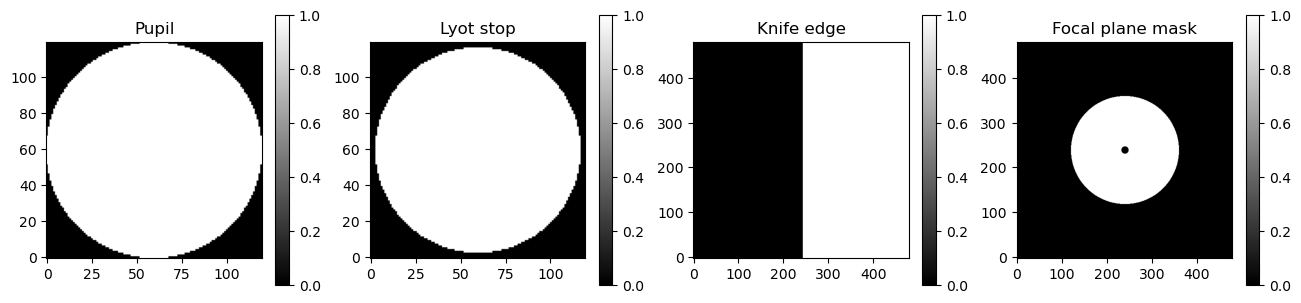

In [6]:
Npix = 120

pupil = 1-get_circular_mask((Npix,Npix),mask_radius=Npix/2)
lyot =  1-get_circular_mask((Npix,Npix),mask_radius=Npix/2*0.95)

oversampling = 4
fp_iwa = 2
fp_owa = 30
fp_stop = get_circular_mask((Npix*oversampling,Npix*oversampling),mask_radius=fp_iwa*oversampling)
fp_stop = xp.logical_and(fp_stop, 1-get_circular_mask((Npix*oversampling,Npix*oversampling),mask_radius=fp_owa*oversampling))

xx,yy = image_grid((Npix*oversampling,Npix*oversampling),recenter=True)
iwa = 1.0
knife_edge = xx >= iwa*oversampling

plt.figure(figsize=(16,3.5))
plt.subplot(1,4,1)
plt.imshow(xp.asnumpy(pupil),origin='lower',cmap='gray')
plt.colorbar()
plt.title('Pupil')
plt.subplot(1,4,2)
plt.imshow(xp.asnumpy(lyot),origin='lower',cmap='gray')
plt.colorbar()
plt.title('Lyot stop')
plt.subplot(1,4,3)
plt.imshow(xp.asnumpy(knife_edge),origin='lower',cmap='gray')
plt.colorbar()
plt.title('Knife edge')
plt.subplot(1,4,4)
plt.imshow(xp.asnumpy(fp_stop),origin='lower',cmap='gray')
plt.colorbar()
plt.title('Focal plane mask')

Text(0.5, 1.0, 'Target (anular) contrast')

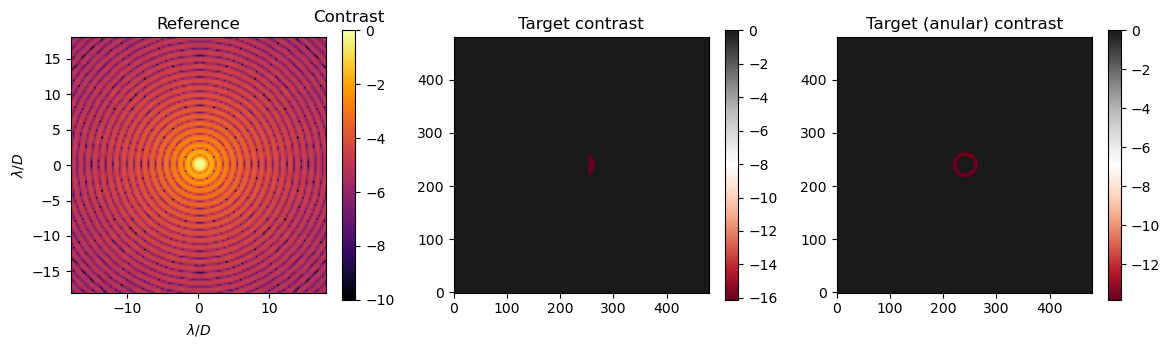

In [7]:
psf = calc_psf(pupil.astype(xp.complex64),oversampling=oversampling)

dark_zone = define_target_roi(pupil, iwa=3, owa=6, oversampling=oversampling)
target_contrast = xp.ones_like(psf)
target_contrast[dark_zone] = 1e-7

anular_dark_zone = define_target_roi(pupil, iwa=4, owa=6, symmetric=True, oversampling=oversampling)
anular_target_contrast = xp.ones_like(psf)
anular_target_contrast[anular_dark_zone] = 1e-6

plt.figure(figsize=(14,3.5))
plt.subplot(1,3,1)
show_psf(psf,oversampling=oversampling,title='Reference')
plt.subplot(1,3,2)
plt.imshow(xp.asnumpy(xp.log(target_contrast)),origin='lower',cmap='RdGy')
plt.colorbar()
plt.title('Target contrast')
plt.subplot(1,3,3)
plt.imshow(xp.asnumpy(xp.log(anular_target_contrast)),origin='lower',cmap='RdGy')
plt.colorbar()
plt.title('Target (anular) contrast')


In [8]:
phase = gs_lyot(pupil, target_contrast, oversampling=oversampling, max_its=3000, beta=0.95)
phase_lyot = gs_lyot(pupil, anular_target_contrast, oversampling=oversampling, max_its=3000, beta=0.95) #lyot=lyot, focal_mask=fp_stop, 

Apodizer computed in 2031 iterations: average contrast in dark hole is -8.5, Strehl is 81.65%
Apodizer computed in 2506 iterations: average contrast in dark hole is -7.8, Strehl is 50.51%


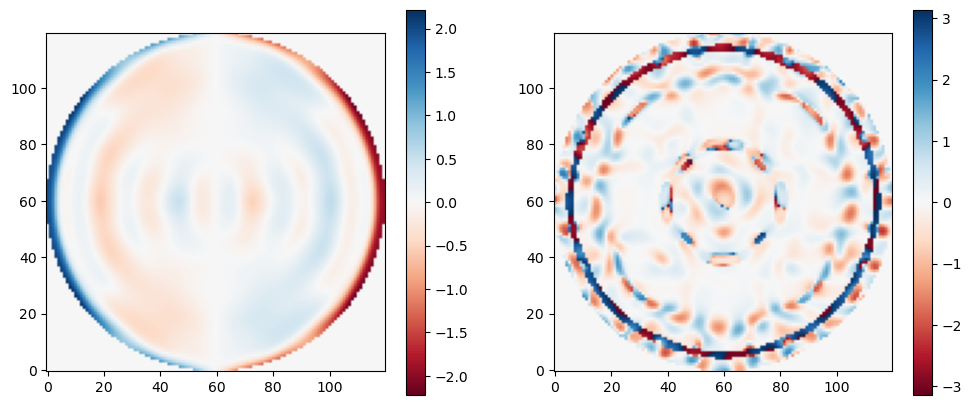

In [9]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(xp.asnumpy(phase),origin='lower',cmap='RdBu')
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(xp.asnumpy(phase_lyot),origin='lower',cmap='RdBu')
plt.colorbar()

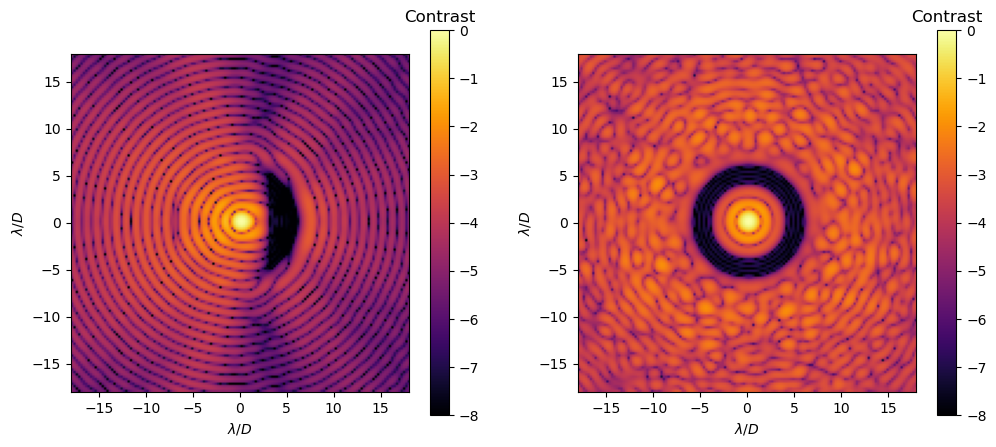

In [10]:
ef = pupil * xp.exp(1j*phase,dtype=xp.complex64)
apo_psf = calc_psf(ef, oversampling=4)

ef = pupil * xp.exp(1j*phase_lyot,dtype=xp.complex64)
coro_psf = calc_psf(ef, oversampling=4)#, fp_mask=fp_stop, lyot_stop=lyot)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
show_psf(apo_psf,oversampling=4,vmin=-8)
plt.subplot(1,2,2)
show_psf(coro_psf,oversampling=4,vmin=-8)

In [11]:
ovs = 4

dark_zone = define_target_roi(pupil, iwa=6, owa=9, oversampling=ovs)
target_contrast = xp.ones((Npix*ovs,Npix*ovs))
target_contrast[dark_zone] = 1e-9
app_phase = gs_lyot(pupil, target_contrast, oversampling=ovs, max_its=2000, beta=0.95)

Maximum number of iterations (2000) reached, worst contrast in dark hole is: -7.7


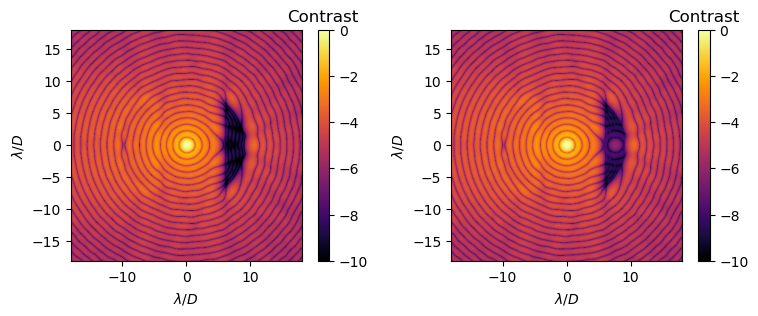

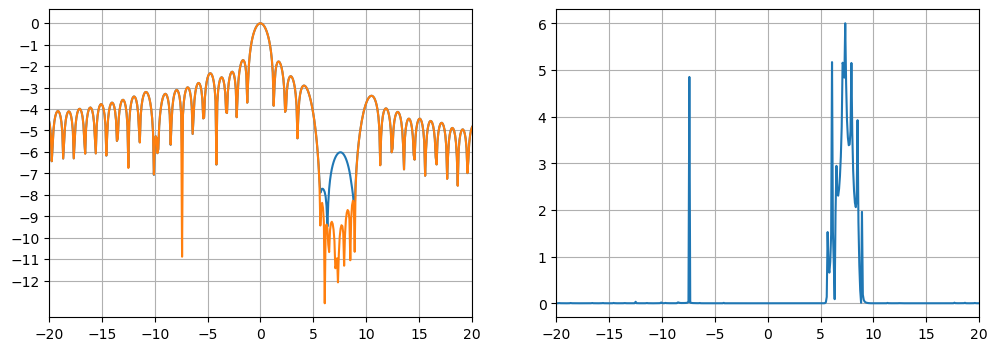

In [12]:
f = 7.5
lambdaInM = 400e-9
amp = lambdaInM/(10**3.5)

plot_speckle_amplitude(pupil, speckleAmp=amp, speckleLambdaOverD=f, app_phase=app_phase, lambdaInM=lambdaInM, oversampling=12)


Maximum number of iterations (6000) reached, worst contrast in dark hole is: -6.8


(-13.0, 1.0)

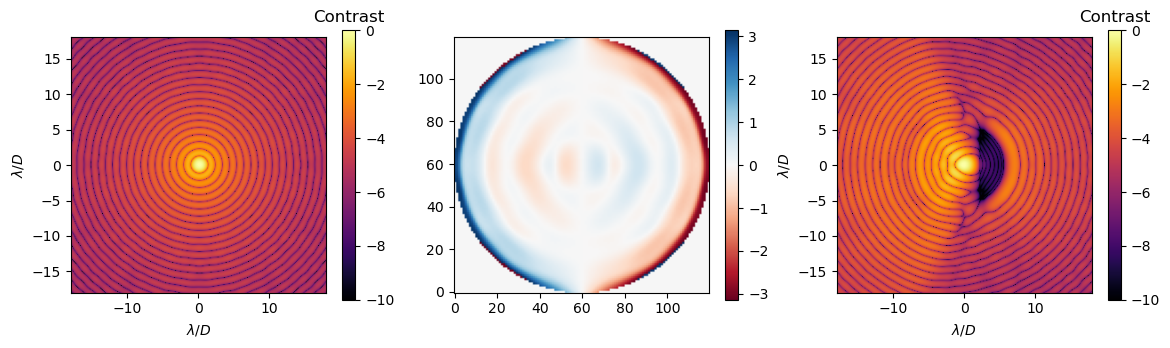

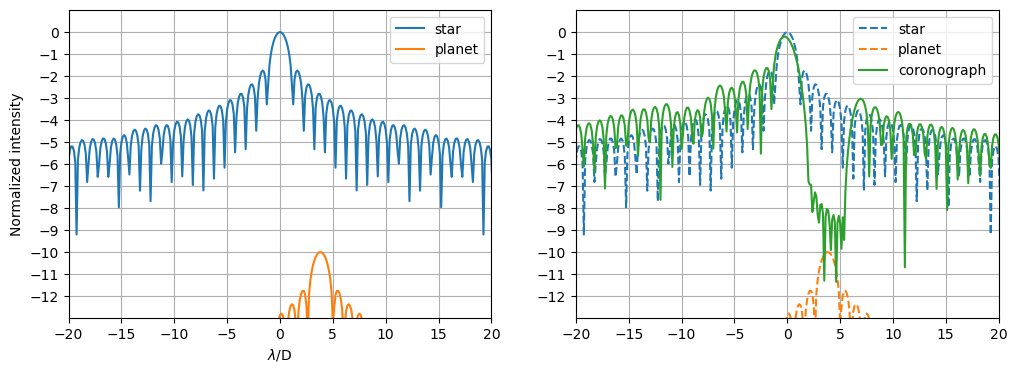

In [13]:
X, Y = image_grid(pupil.shape, recenter=True)
Xv = X[pupil.astype(bool)]/max(pupil.shape)
Yv = Y[pupil.astype(bool)]/max(pupil.shape)

brightness = xp.sqrt(1e-10)
ovs = 8
ampX = 3*ovs
ampY = 0*ovs
tilt = reshape_on_mask(Xv * ampX + Yv * ampY,(1-pupil).astype(bool))

faint_companion = pupil * xp.exp(1j*tilt,dtype=xp.complex64) * brightness
star = pupil.astype(xp.complex64)

psf = calc_psf(star+faint_companion)
dark_zone = define_target_roi(pupil, iwa=2, owa=5.5, oversampling=ovs)
target_contrast = xp.ones((Npix*ovs,Npix*ovs))
target_contrast[dark_zone] = 1e-7
app_phase = gs_lyot(pupil, target_contrast, oversampling=ovs, max_its=6000, beta=0.975)
apo_psf = calc_psf((star+faint_companion)*xp.exp(1j*app_phase,dtype=xp.complex64))

plt.figure(figsize=(14,3.5))
plt.subplot(1,3,1)
show_psf(psf)
plt.subplot(1,3,2)
plt.imshow(xp.asnumpy(app_phase),origin='lower',cmap='RdBu')
plt.colorbar()
plt.subplot(1,3,3)
show_psf(apo_psf)

star_psf = calc_psf(star)
planet_psf = calc_psf(faint_companion)

sz = max(psf.shape)
star_psf_slice = xp.log10(star_psf[sz//2+1,:]/xp.max(star_psf))
planet_psf_slice = xp.log10(planet_psf[sz//2+1,:]/xp.max(star_psf))
apo_psf_slice = xp.log10(apo_psf[sz//2+1,:]/xp.max(star_psf))

xLambdas = (xp.arange(sz)-sz/2)/ovs

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(xp.asnumpy(xLambdas),xp.asnumpy(star_psf_slice),label='star')
plt.plot(xp.asnumpy(xLambdas),xp.asnumpy(planet_psf_slice),label='planet')
plt.xlabel(r'$\lambda$/D')
plt.ylabel('Normalized intensity')
plt.legend()
plt.xlim([-20,20])
plt.grid()
plt.yticks(xp.asnumpy(xp.arange(13)-12))
plt.ylim([-13,1])
plt.subplot(1,2,2)
plt.plot(xp.asnumpy(xLambdas),xp.asnumpy(star_psf_slice),'--',label='star')
plt.plot(xp.asnumpy(xLambdas),xp.asnumpy(planet_psf_slice),'--',label='planet')
plt.plot(xp.asnumpy(xLambdas),xp.asnumpy(apo_psf_slice),label='coronograph')
plt.grid()
plt.legend()
plt.xlim([-20,20])
plt.yticks(xp.asnumpy(xp.arange(13)-12))
plt.ylim([-13,1])


Maximum number of iterations (6000) reached, worst contrast in dark hole is: -6.8


(-13.0, 1.0)

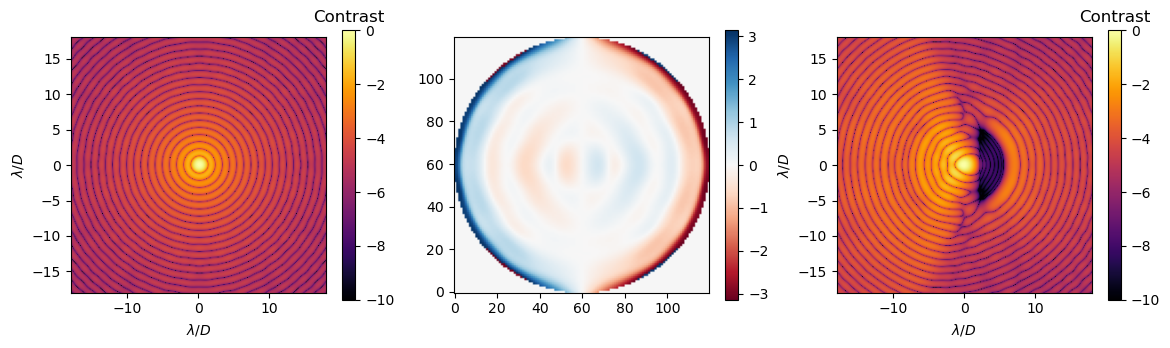

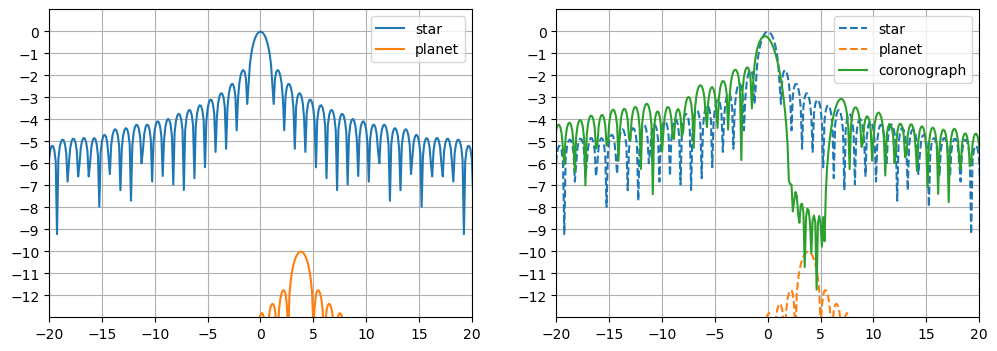

In [14]:
app_phase = gs_lyot(pupil, target_contrast, oversampling=ovs, max_its=6000, beta=0.975, phase_offset=xp.angle(star+faint_companion))
apo_psf = calc_psf((star+faint_companion)*xp.exp(1j*app_phase,dtype=xp.complex64))
apo_psf_slice = xp.log10(apo_psf[sz//2+1,:]/xp.max(star_psf))

plt.figure(figsize=(14,3.5))
plt.subplot(1,3,1)
show_psf(psf)
plt.subplot(1,3,2)
plt.imshow(xp.asnumpy(app_phase),origin='lower',cmap='RdBu')
plt.colorbar()
plt.subplot(1,3,3)
show_psf(apo_psf)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(xp.asnumpy(xLambdas),xp.asnumpy(star_psf_slice),label='star')
plt.plot(xp.asnumpy(xLambdas),xp.asnumpy(planet_psf_slice),label='planet')
plt.legend()
plt.xlim([-20,20])
plt.grid()
plt.yticks(xp.asnumpy(xp.arange(13)-12))
plt.ylim([-13,1])
plt.subplot(1,2,2)
plt.plot(xp.asnumpy(xLambdas),xp.asnumpy(star_psf_slice),'--',label='star')
plt.plot(xp.asnumpy(xLambdas),xp.asnumpy(planet_psf_slice),'--',label='planet')
plt.plot(xp.asnumpy(xLambdas),xp.asnumpy(apo_psf_slice),label='coronograph')
plt.grid()
plt.legend()
plt.xlim([-20,20])
plt.yticks(xp.asnumpy(xp.arange(13)-12))
plt.ylim([-13,1])


Text(0.5, 1.0, 'Residual phase\n(KL removed)')

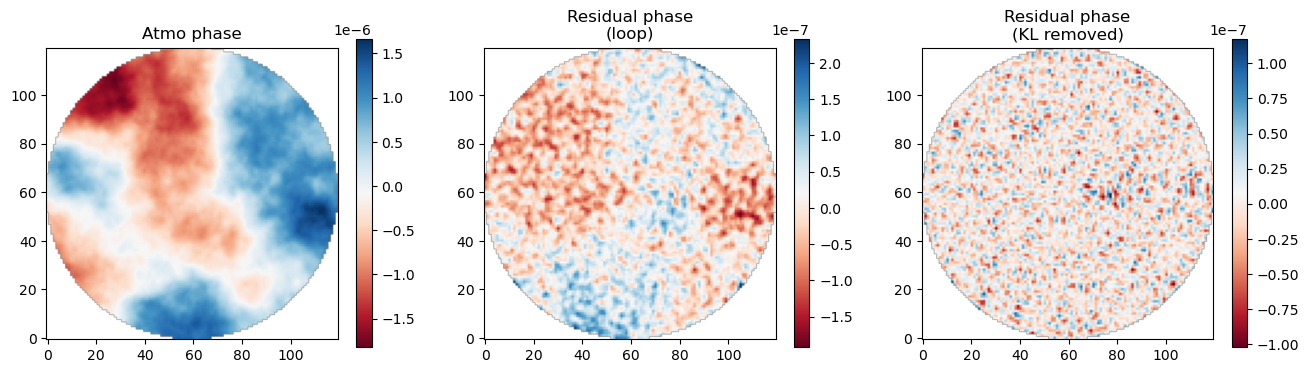

In [15]:
id = 100
m2rad = 2*xp.pi/ssao.pyr.lambdaInM

res_phase = xp.asarray(res_phases[id].data[~res_phases[id].mask])
fit_modes = phase2modes @ res_phase
fit_res = KL.T @ fit_modes
ho_res = res_phase - fit_res


plt.figure(figsize=(16,4))
plt.subplot(1,3,1)
plt.imshow(masked_array(atmo_phases[id].data,atmo_phases[id].mask),origin='lower',cmap='RdBu')
plt.colorbar()
plt.title('Atmo phase')
plt.subplot(1,3,2)
plt.imshow(masked_array(res_phases[id].data,res_phases[id].mask),origin='lower',cmap='RdBu')
plt.colorbar()
plt.title('Residual phase\n(loop)')
plt.subplot(1,3,3)
plt.imshow(masked_array(xp.asnumpy(reshape_on_mask(ho_res,ssao.cmask)),res_phases[id].mask),origin='lower',cmap='RdBu')
plt.colorbar()
plt.title('Residual phase\n(KL removed)')

Maximum number of iterations (6000) reached, worst contrast in dark hole is: -5.2
Maximum number of iterations (6000) reached, worst contrast in dark hole is: -5.6


(-13.0, 1.0)

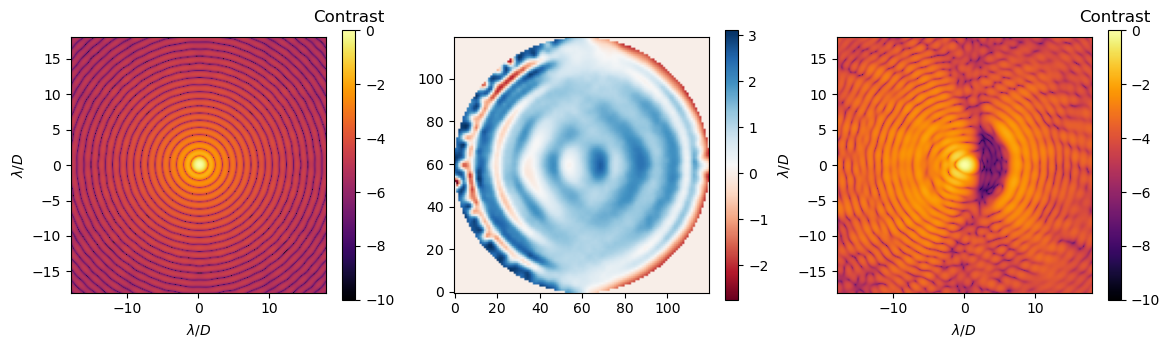

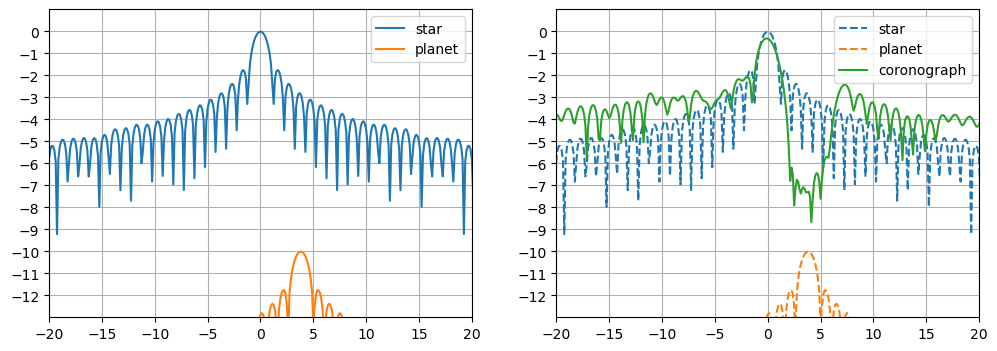

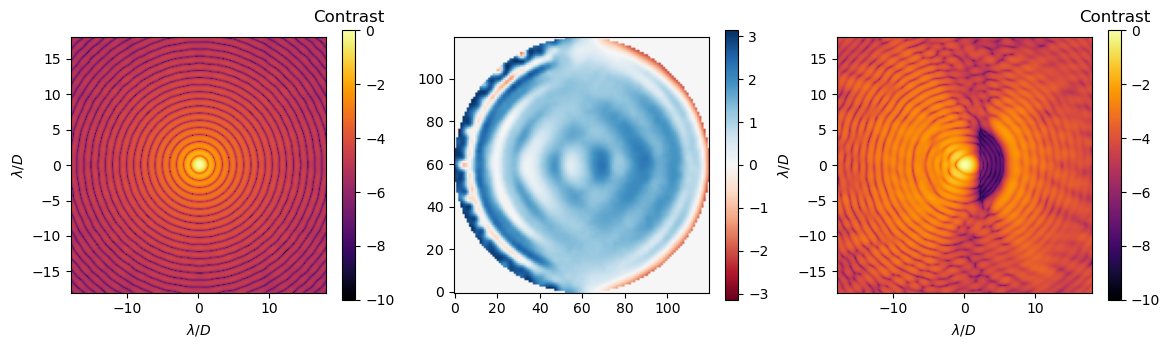

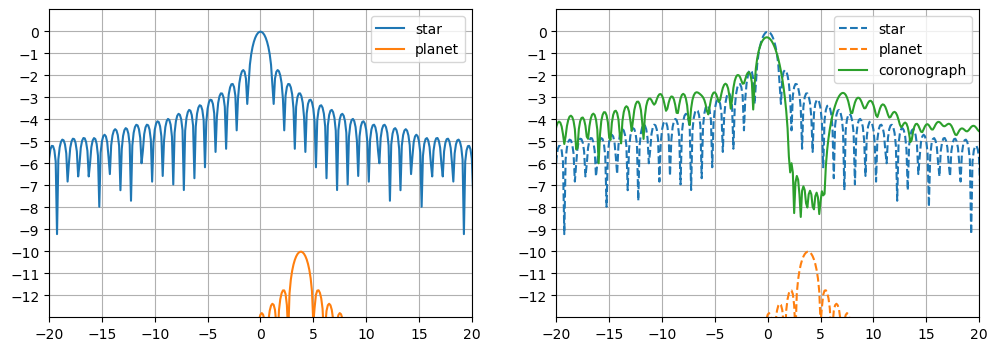

In [16]:
loop_phi_offset = reshape_on_mask(ho_res * m2rad,ssao.cmask)
damp = 20

psf = calc_psf((star+faint_companion)*xp.exp(1j*loop_phi_offset/damp,dtype=xp.complex64))
app_phase = gs_lyot(pupil, target_contrast, oversampling=ovs, max_its=6000, beta=0.975, phase_offset=loop_phi_offset/damp, IF=ssao.dm.IFF)
apo_psf = calc_psf((star+faint_companion)*xp.exp(1j*app_phase,dtype=xp.complex64))
apo_psf_slice = xp.log10(apo_psf[sz//2+1,:]/xp.max(star_psf))

plt.figure(figsize=(14,3.5))
plt.subplot(1,3,1)
show_psf(psf)
plt.subplot(1,3,2)
plt.imshow(xp.asnumpy(app_phase),origin='lower',cmap='RdBu')
plt.colorbar()
plt.subplot(1,3,3)
show_psf(apo_psf)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(xp.asnumpy(xLambdas),xp.asnumpy(star_psf_slice),label='star')
plt.plot(xp.asnumpy(xLambdas),xp.asnumpy(planet_psf_slice),label='planet')
plt.legend()
plt.xlim([-20,20])
plt.grid()
plt.yticks(xp.asnumpy(xp.arange(13)-12))
plt.ylim([-13,1])
plt.subplot(1,2,2)
plt.plot(xp.asnumpy(xLambdas),xp.asnumpy(star_psf_slice),'--',label='star')
plt.plot(xp.asnumpy(xLambdas),xp.asnumpy(planet_psf_slice),'--',label='planet')
plt.plot(xp.asnumpy(xLambdas),xp.asnumpy(apo_psf_slice),label='coronograph')
plt.grid()
plt.legend()
plt.xlim([-20,20])
plt.yticks(xp.asnumpy(xp.arange(13)-12))
plt.ylim([-13,1])

app_phase = gs_lyot(pupil, target_contrast, oversampling=ovs, max_its=6000, beta=0.95, phase_offset=loop_phi_offset/damp+xp.angle(star+faint_companion), IF=ssao.dm.IFF)
apo_psf = calc_psf((star+faint_companion)*xp.exp(1j*app_phase,dtype=xp.complex64))
apo_psf_slice = xp.log10(apo_psf[sz//2+1,:]/xp.max(star_psf))

plt.figure(figsize=(14,3.5))
plt.subplot(1,3,1)
show_psf(psf)
plt.subplot(1,3,2)
plt.imshow(xp.asnumpy(app_phase),origin='lower',cmap='RdBu')
plt.colorbar()
plt.subplot(1,3,3)
show_psf(apo_psf)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(xp.asnumpy(xLambdas),xp.asnumpy(star_psf_slice),label='star')
plt.plot(xp.asnumpy(xLambdas),xp.asnumpy(planet_psf_slice),label='planet')
plt.legend()
plt.xlim([-20,20])
plt.grid()
plt.yticks(xp.asnumpy(xp.arange(13)-12))
plt.ylim([-13,1])
plt.subplot(1,2,2)
plt.plot(xp.asnumpy(xLambdas),xp.asnumpy(star_psf_slice),'--',label='star')
plt.plot(xp.asnumpy(xLambdas),xp.asnumpy(planet_psf_slice),'--',label='planet')
plt.plot(xp.asnumpy(xLambdas),xp.asnumpy(apo_psf_slice),label='coronograph')
plt.grid()
plt.legend()
plt.xlim([-20,20])
plt.yticks(xp.asnumpy(xp.arange(13)-12))
plt.ylim([-13,1])

In [17]:
# ovs = 12
# hpf = get_circular_mask((Npix*ovs,Npix*ovs),mask_radius=12*ovs)
# lpf = 1-hpf

# phi_offset = reshape_on_mask(res_phase * m2rad,ssao.cmask)
# ef = pupil * xp.exp(1j*phi_offset,dtype=xp.complex64)
# pad_ef = xp.pad(ef, pad_width=max(ef.shape)*(ovs-1)//2, mode='constant', constant_values=0.0)
# ff = xp.fft.fftshift(xp.fft.fft2(pad_ef))
# hff = xp.abs(ff) * xp.exp(1j*xp.angle(ff)*hpf,dtype=xp.complex64)
# lff = xp.abs(ff) * xp.exp(1j*xp.angle(ff)*lpf,dtype=xp.complex64)
# hpupf = xp.fft.ifft2(xp.fft.ifftshift(hff))
# lpupf = xp.fft.ifft2(xp.fft.ifftshift(lff))
# ho_phase = xp.angle(hpupf)[(xp.abs(pad_ef)>0).astype(bool)]
# ho_phi_offset = reshape_on_mask(ho_phase,ssao.cmask)
# lo_phase = xp.angle(lpupf)[(xp.abs(pad_ef)>0).astype(bool)]
# lo_phi_offset = reshape_on_mask(lo_phase,ssao.cmask)

# plt.figure(figsize=(14,7))
# plt.subplot(2,3,1)
# plt.imshow(masked_array(xp.asnumpy(ho_phi_offset/m2rad),res_phases[id].mask),origin='lower',cmap='RdBu')
# plt.colorbar()
# plt.title('Residual phase\n(High-pass filtered)')
# plt.subplot(2,3,2)
# plt.imshow(masked_array(xp.asnumpy(lo_phi_offset/m2rad),res_phases[id].mask),origin='lower',cmap='RdBu')
# plt.colorbar()
# plt.title('Residual phase\n(Low-pass filtered)')
# plt.subplot(2,3,3)
# plt.imshow(masked_array(xp.asnumpy((lo_phi_offset+ho_phi_offset)/m2rad),res_phases[id].mask),origin='lower',cmap='RdBu')
# plt.colorbar()
# plt.title('Residual phase\n(Low-pass + high-pass filtered)')
# plt.subplot(2,3,4)
# ef = pupil * xp.exp(1j*ho_phi_offset,dtype=xp.complex64)
# show_psf(calc_psf(ef))
# plt.subplot(2,3,5)
# ef = pupil * xp.exp(1j*lo_phi_offset,dtype=xp.complex64)
# show_psf(calc_psf(ef))
# plt.subplot(2,3,6)
# ef = pupil * xp.exp(1j*(lo_phi_offset+ho_phi_offset),dtype=xp.complex64)
# show_psf(calc_psf(ef))

In [18]:
# ef = pupil * xp.exp(1j*(phase+loop_phi_offset),dtype=xp.complex64)
# ab_apo_psf = calc_psf(ef, oversampling=4)

# ef = pupil * xp.exp(1j*(phase_lyot+loop_phi_offset),dtype=xp.complex64)
# ab_coro_psf = calc_psf(ef, oversampling=4)#, fp_mask=fp_stop, lyot_stop=lyot)

# ef = pupil * xp.exp(1j*(phase+ho_phi_offset),dtype=xp.complex64)
# ho_apo_psf = calc_psf(ef, oversampling=4)

# ef = pupil * xp.exp(1j*(phase_lyot+ho_phi_offset),dtype=xp.complex64)
# ho_coro_psf = calc_psf(ef, oversampling=4)#, fp_mask=fp_stop, lyot_stop=lyot)

# plt.figure(figsize=(14,8))
# plt.subplot(2,3,1)
# show_psf(apo_psf,oversampling=4,vmin=-8)
# plt.subplot(2,3,4)
# show_psf(coro_psf,oversampling=4,vmin=-8)
# plt.subplot(2,3,2)
# show_psf(ab_apo_psf,oversampling=4,vmin=-8)
# plt.subplot(2,3,5)
# show_psf(ab_coro_psf,oversampling=4,vmin=-8)
# plt.subplot(2,3,3)
# show_psf(ho_apo_psf,oversampling=4,vmin=-8)
# plt.subplot(2,3,6)
# show_psf(ho_coro_psf,oversampling=4,vmin=-8)